In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
%cd '/content/drive/MyDrive/NLU_NCKH/notebook/'

/content/drive/MyDrive/NLU_NCKH/notebook


In [2]:
!pip install --q emoji underthesea pyvi

# Import libraty

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
# from python_calamine.pandas import pandas_monkeypatch

# Load data and format data -> csv

In [4]:
restaurant_train = './Res_ABSA/Train.txt'
restaurant_test = './Res_ABSA/Test.txt'
restaurant_dev = './Res_ABSA/Dev.txt'

aspects = ['SERVICE#GENERAL',
  'LOCATION#GENERAL',
  'RESTAURANT#GENERAL',
  'AMBIENCE#GENERAL',
  'FOOD#PRICES',
  'RESTAURANT#MISCELLANEOUS',
  'DRINKS#PRICES',
  'FOOD#QUALITY',
  'FOOD#STYLE&OPTIONS',
  'RESTAURANT#PRICES',
  'DRINKS#QUALITY',
  'DRINKS#STYLE&OPTIONS']

def label_encoder(label, aspects):
    y = [0] * len(aspects)
    ap_stm = re.findall('{(.+?), (\w+)}', label)
    for aspect, sentiment in ap_stm:
        idx = aspects.index(aspect)
        y[idx] = sentiment

    return y

def init_data(df):
    X = df['review']
    y = df.drop('review', axis=1).replace({'negative': 1,
                    'neutral': 2,
                    'positive': 3}).astype(np.uint8)

    print('X.shape:', X.shape, 'y.shape:', y.shape)
    return X, y

def txt2df(filepath, aspect):
    with open(filepath, 'r', encoding='utf-8-sig') as txt:
        data = txt.read().split('\n')

    df = pd.DataFrame()
    df['review'] = [review for review in data[1::4]]
    df[aspect] = [label_encoder(label, aspect) for label in data[2::4]]
    df[aspect] = df[aspect].replace({'negative': 1,
                    'neutral': 2,
                    'positive': 3}).astype(np.uint8)
    return df


train = txt2df(restaurant_train, aspects)
dev = txt2df(restaurant_dev, aspects)
test = txt2df(restaurant_test, aspects)

Xtrain, ytrain = init_data(train)
Xdev,   ydev   = init_data(dev)
Xtest,  ytest  = init_data(test)

X.shape: (7028,) y.shape: (7028, 12)
X.shape: (771,) y.shape: (771, 12)
X.shape: (1938,) y.shape: (1938, 12)


In [ ]:
for data in [Xtrain, Xtest, Xdev]:
    max = np.max([len(s) for s in data])
    mean = np.average([len(s) for s in data])
    std = np.std([len(s) for s in data])
    print(f'Max: {max}, Mean: {mean}, Std: {std}')

Max: 419, Mean: 71.40623221400114, Std: 39.857110332135655
Max: 341, Mean: 71.23632610939113, Std: 39.77873374985621
Max: 260, Mean: 71.28664072632944, Std: 38.24061395481708


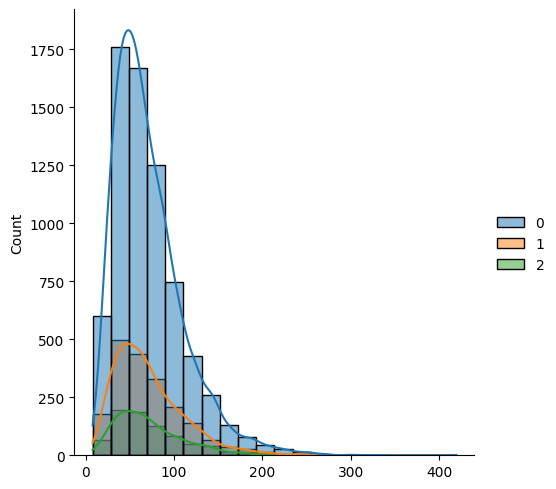

In [ ]:
import seaborn as sns

sns.displot([
    [len(s) for s in Xtrain],
    [len(s) for s in Xtest],
    [len(s) for s in Xdev]
], kde=True, bins=20)

In [ ]:
aspect_sentiment_count = {
    'Aspect': [],
    'Positive': [],
    'Neutral': [],
    'Negative': []
}

# Duyệt qua từng aspect
for aspect in aspects:
    value_counts = pd.concat([train, dev, test])[aspect].value_counts()
    positive = value_counts.get(3, 0)
    neutral = value_counts.get(2, 0)
    negative = value_counts.get(1, 0)

    aspect_sentiment_count['Aspect'].append(aspect)
    aspect_sentiment_count['Positive'].append(positive)
    aspect_sentiment_count['Neutral'].append(neutral)
    aspect_sentiment_count['Negative'].append(negative)

# Chuyển dictionary thành DataFrame
df = pd.DataFrame(aspect_sentiment_count)
df
# Xuất DataFrame thành file Excel
# df.to_excel('aspect_sentiment_count.xlsx', index=False)

# print("Đã xuất dữ liệu thành công vào file 'aspect_sentiment_count.xlsx'")

,Aspect,Positive,Neutral,Negative
0,SERVICE#GENERAL,870,125,522
1,LOCATION#GENERAL,237,236,46
2,RESTAURANT#GENERAL,742,326,185
3,AMBIENCE#GENERAL,754,171,208
4,FOOD#PRICES,129,358,71
5,RESTAURANT#MISCELLANEOUS,410,108,208
6,DRINKS#PRICES,45,145,46
7,FOOD#QUALITY,1929,421,421
8,FOOD#STYLE&OPTIONS,1048,825,310
9,RESTAURANT#PRICES,192,260,133


In [ ]:
dict_aspect_per_dataset = {}
dict_sentiment_per_dataset = {}

for type_data, dataset in zip(["train", "test", "dev"], [train, test, dev]):
    value_counts_all = dataset[aspects].apply(pd.Series.value_counts)

    value_counts_filtered = value_counts_all.loc[[1, 2, 3]]

    dict_aspect_per_dataset[type_data] = value_counts_filtered.sum().sum()

    dict_sentiment_per_dataset[type_data] = {
        "positive": value_counts_all.loc[3].sum(),
        "neutral": value_counts_all.loc[2].sum(),
        "negative": value_counts_all.loc[1].sum()
    }

dict_aspect_per_dataset, dict_sentiment_per_dataset


dict_aspect_per_dataset, dict_sentiment_per_dataset

({'train': 9458, 'test': 2629, 'dev': 1053},
 {'train': {'positive': 5179, 'neutral': 2533, 'negative': 1746},
  'test': {'positive': 1503, 'neutral': 691, 'negative': 435},
  'dev': {'positive': 579, 'neutral': 278, 'negative': 196}})

# Preprocessing

In [5]:
vowels_table = [
    ['a', 'à', 'á', 'ả', 'ã', 'ạ', 'a' ],
    ['ă', 'ằ', 'ắ', 'ẳ', 'ẵ', 'ặ', 'aw'],
    ['â', 'ầ', 'ấ', 'ẩ', 'ẫ', 'ậ', 'aa'],
    ['e', 'è', 'é', 'ẻ', 'ẽ', 'ẹ', 'e' ],
    ['ê', 'ề', 'ế', 'ể', 'ễ', 'ệ', 'ee'],
    ['i', 'ì', 'í', 'ỉ', 'ĩ', 'ị', 'i' ],
    ['o', 'ò', 'ó', 'ỏ', 'õ', 'ọ', 'o' ],
    ['ô', 'ồ', 'ố', 'ổ', 'ỗ', 'ộ', 'oo'],
    ['ơ', 'ờ', 'ớ', 'ở', 'ỡ', 'ợ', 'ow'],
    ['u', 'ù', 'ú', 'ủ', 'ũ', 'ụ', 'u' ],
    ['ư', 'ừ', 'ứ', 'ử', 'ữ', 'ự', 'uw'],
    ['y', 'ỳ', 'ý', 'ỷ', 'ỹ', 'ỵ', 'y' ]
]

# Normalize acronyms
# !wget https://gist.githubusercontent.com/nguyenvanhieuvn/7d9441c10b3c2739499fc5a4d9ea06fb/raw/df939245b3e841b62af115be4dcb3516dadc9fc5/teencode.txt
replace_list = {
    'ô kêi': 'ok', 'okie': 'ok', 'o kê': 'ok', 'okey': 'ok', 'ôkê': 'ok', 'oki': 'ok', 'oke': 'ok', 'okay': 'ok', 'okê': 'ok',
    'tks': 'cảm ơn', 'thks': 'cảm ơn', 'thanks': 'cảm ơn', 'ths': 'cảm ơn', 'thank': 'cảm ơn',
    'kg': 'không', 'not': 'không', 'k': 'không', 'kh': 'không', 'kô': 'không', 'hok': 'không', 'ko': 'không', 'khong': 'không', 'kp': 'không phải',
    'he he': 'tích cực', 'hehe': 'tích cực', 'hihi': 'tích cực', 'haha': 'tích cực', 'hjhj': 'tích cực', 'thick': 'tích cực',
    'cc': 'tiêu cực', 'huhu': 'tiêu cực', 'cute': 'dễ thương',

    'sz': 'cỡ', 'size': 'cỡ',
    'wa': 'quá', 'wá': 'quá', 'qá': 'quá',
    'đx': 'được', 'dk': 'được', 'dc': 'được', 'đk': 'được', 'đc': 'được',
    'vs': 'với', 'j': 'gì', '“': ' ', 'time': 'thời gian', 'm': 'mình', 'mik': 'mình', 'r': 'rồi', 'bjo': 'bao giờ', 'very': 'rất',

    'authentic': 'chuẩn chính hãng', 'aut': 'chuẩn chính hãng', 'auth': 'chuẩn chính hãng', 'date': 'hạn sử dụng', 'hsd': 'hạn sử dụng',
    'store': 'cửa hàng', 'sop': 'cửa hàng', 'shopE': 'cửa hàng', 'shop': 'cửa hàng',
    'sp': 'sản phẩm', 'product': 'sản phẩm', 'hàg': 'hàng',
    'ship': 'giao hàng', 'delivery': 'giao hàng', 'síp': 'giao hàng', 'order': 'đặt hàng',

    'gud': 'tốt', 'wel done': 'tốt', 'good': 'tốt', 'gút': 'tốt', 'tot': 'tốt', 'nice': 'tốt', 'perfect': 'rất tốt',
    'quality': 'chất lượng', 'chất lg': 'chất lượng', 'chat': 'chất', 'excelent': 'hoàn hảo', 'bt': 'bình thường',
    'sad': 'tệ', 'por': 'tệ', 'poor': 'tệ', 'bad': 'tệ',
    'beautiful': 'đẹp tuyệt vời', 'dep': 'đẹp',
    'xau': 'xấu', 'sấu': 'xấu',

    'thik': 'thích', 'iu': 'yêu', 'fake': 'giả mạo',
    'quickly': 'nhanh', 'quick': 'nhanh', 'fast': 'nhanh',
    'fresh': 'tươi', 'delicious': 'ngon',

    'dt': 'điện thoại', 'fb': 'facebook', 'face': 'facebook', 'ks': 'khách sạn', 'nv': 'nhân viên',
    'nt': 'nhắn tin', 'ib': 'nhắn tin', 'tl': 'trả lời', 'trl': 'trả lời', 'rep': 'trả lời',
    'fback': 'feedback', 'fedback': 'feedback',
    'sd': 'sử dụng', 'sài': 'xài',

    '^_^': 'tích cực', ':)': 'tích cực', ':(': 'tiêu cực',
    '❤️': 'tích cực', '👍': 'tích cực', '🎉': 'tích cực', '😀': 'tích cực', '😍': 'tích cực', '😂': 'tích cực', '🤗': 'tích cực', '😙': 'tích cực', '🙂': 'tích cực',
    '😔': 'tiêu cực', '😓': 'tiêu cực',
    '⭐': 'star', '*': 'star', '🌟': 'star',
}

In [17]:
%cd ../

[Errno 2] No such file or directory: './uit_word_segmentation'
/content/drive/MyDrive/NLU_NCKH/notebook/uit_word_segmentation
/content/drive/MyDrive/NLU_NCKH/notebook


In [10]:
# https://github.com/nguyenvanhieuvn/text-classification-tutorial/blob/master/text_classification_tutorial.ipynb
# https://nguyenvanhieu.vn/phan-loai-van-ban-tieng-viet

import regex as re
import string
import emoji

#from vncorenlp import VnCoreNLP
import underthesea
from nltk import flatten
# from UITws_v1 import UITws_v1
from pyvi import ViTokenizer

# Word segment from UIT (https://github.com/vuraemon/UITws-v1/)
# uitws_v1 = UITws_v1('./base_long_sep_sfx.pkl')

# Remove HTML code
def remove_HTML(text):
    return re.sub(r'<[^>]*>', '', text)

# Standardize unicode
def convert_unicode(text):
    char1252 = 'à|á|ả|ã|ạ|ầ|ấ|ẩ|ẫ|ậ|ằ|ắ|ẳ|ẵ|ặ|è|é|ẻ|ẽ|ẹ|ề|ế|ể|ễ|ệ|ì|í|ỉ|ĩ|ị|ò|ó|ỏ|õ|ọ|ồ|ố|ổ|ỗ|ộ|ờ|ớ|ở|ỡ|ợ|ù|ú|ủ|ũ|ụ|ừ|ứ|ử|ữ|ự|ỳ|ý|ỷ|ỹ|ỵ|À|Á|Ả|Ã|Ạ|Ầ|Ấ|Ẩ|Ẫ|Ậ|Ằ|Ắ|Ẳ|Ẵ|Ặ|È|É|Ẻ|Ẽ|Ẹ|Ề|Ế|Ể|Ễ|Ệ|Ì|Í|Ỉ|Ĩ|Ị|Ò|Ó|Ỏ|Õ|Ọ|Ồ|Ố|Ổ|Ỗ|Ộ|Ờ|Ớ|Ở|Ỡ|Ợ|Ù|Ú|Ủ|Ũ|Ụ|Ừ|Ứ|Ử|Ữ|Ự|Ỳ|Ý|Ỷ|Ỹ|Ỵ'
    charutf8 = 'à|á|ả|ã|ạ|ầ|ấ|ẩ|ẫ|ậ|ằ|ắ|ẳ|ẵ|ặ|è|é|ẻ|ẽ|ẹ|ề|ế|ể|ễ|ệ|ì|í|ỉ|ĩ|ị|ò|ó|ỏ|õ|ọ|ồ|ố|ổ|ỗ|ộ|ờ|ớ|ở|ỡ|ợ|ù|ú|ủ|ũ|ụ|ừ|ứ|ử|ữ|ự|ỳ|ý|ỷ|ỹ|ỵ|À|Á|Ả|Ã|Ạ|Ầ|Ấ|Ẩ|Ẫ|Ậ|Ằ|Ắ|Ẳ|Ẵ|Ặ|È|É|Ẻ|Ẽ|Ẹ|Ề|Ế|Ể|Ễ|Ệ|Ì|Í|Ỉ|Ĩ|Ị|Ò|Ó|Ỏ|Õ|Ọ|Ồ|Ố|Ổ|Ỗ|Ộ|Ờ|Ớ|Ở|Ỡ|Ợ|Ù|Ú|Ủ|Ũ|Ụ|Ừ|Ứ|Ử|Ữ|Ự|Ỳ|Ý|Ỷ|Ỹ|Ỵ'
    char1252 = char1252.split('|')
    charutf8 = charutf8.split('|')

    dic = {}
    for i in range(len(char1252)): dic[char1252[i]] = charutf8[i]
    return re.sub(
        r'à|á|ả|ã|ạ|ầ|ấ|ẩ|ẫ|ậ|ằ|ắ|ẳ|ẵ|ặ|è|é|ẻ|ẽ|ẹ|ề|ế|ể|ễ|ệ|ì|í|ỉ|ĩ|ị|ò|ó|ỏ|õ|ọ|ồ|ố|ổ|ỗ|ộ|ờ|ớ|ở|ỡ|ợ|ù|ú|ủ|ũ|ụ|ừ|ứ|ử|ữ|ự|ỳ|ý|ỷ|ỹ|ỵ|À|Á|Ả|Ã|Ạ|Ầ|Ấ|Ẩ|Ẫ|Ậ|Ằ|Ắ|Ẳ|Ẵ|Ặ|È|É|Ẻ|Ẽ|Ẹ|Ề|Ế|Ể|Ễ|Ệ|Ì|Í|Ỉ|Ĩ|Ị|Ò|Ó|Ỏ|Õ|Ọ|Ồ|Ố|Ổ|Ỗ|Ộ|Ờ|Ớ|Ở|Ỡ|Ợ|Ù|Ú|Ủ|Ũ|Ụ|Ừ|Ứ|Ử|Ữ|Ự|Ỳ|Ý|Ỷ|Ỹ|Ỵ',
        lambda x: dic[x.group()], text
    )

# Standardize accent typing
vowels_to_ids = {}

for i in range(len(vowels_table)):
    for j in range(len(vowels_table[i]) - 1):
        vowels_to_ids[vowels_table[i][j]] = (i, j)


def is_valid_vietnamese_word(word):
    chars = list(word)
    vowel_indexes = -1
    for index, char in enumerate(chars):
        x, y = vowels_to_ids.get(char, (-1, -1))
        if x != -1:
            if vowel_indexes == -1: vowel_indexes = index
            else:
                if index - vowel_indexes != 1: return False
                vowel_indexes = index
    return True


def standardize_word_typing(word):
    if not is_valid_vietnamese_word(word): return word
    chars = list(word)
    dau_cau = 0
    vowel_indexes = []
    qu_or_gi = False

    for index, char in enumerate(chars):
        x, y = vowels_to_ids.get(char, (-1, -1))
        if x == -1: continue
        elif x == 9:  # check qu
            if index != 0 and chars[index - 1] == 'q':
                chars[index] = 'u'
                qu_or_gi = True
        elif x == 5:  # check gi
            if index != 0 and chars[index - 1] == 'g':
                chars[index] = 'i'
                qu_or_gi = True

        if y != 0:
            dau_cau = y
            chars[index] = vowels_table[x][0]

        if not qu_or_gi or index != 1:
            vowel_indexes.append(index)

    if len(vowel_indexes) < 2:
        if qu_or_gi:
            if len(chars) == 2:
                x, y = vowels_to_ids.get(chars[1])
                chars[1] = vowels_table[x][dau_cau]
            else:
                x, y = vowels_to_ids.get(chars[2], (-1, -1))
                if x != -1: chars[2] = vowels_table[x][dau_cau]
                else: chars[1] = vowels_table[5][dau_cau] if chars[1] == 'i' else vowels_table[9][dau_cau]
            return ''.join(chars)
        return word

    for index in vowel_indexes:
        x, y = vowels_to_ids[chars[index]]
        if x == 4 or x == 8:  # ê, ơ
            chars[index] = vowels_table[x][dau_cau]
            return ''.join(chars)

    if len(vowel_indexes) == 2:
        if vowel_indexes[-1] == len(chars) - 1:
            x, y = vowels_to_ids[chars[vowel_indexes[0]]]
            chars[vowel_indexes[0]] = vowels_table[x][dau_cau]
        else:
            x, y = vowels_to_ids[chars[vowel_indexes[1]]]
            chars[vowel_indexes[1]] = vowels_table[x][dau_cau]
    else:
        x, y = vowels_to_ids[chars[vowel_indexes[1]]]
        chars[vowel_indexes[1]] = vowels_table[x][dau_cau]
    return ''.join(chars)


def standardize_sentence_typing(text):
    words = text.lower().split()
    for index, word in enumerate(words):
        cw = re.sub(r'(^\p{P}*)([p{L}.]*\p{L}+)(\p{P}*$)', r'\1/\2/\3', word).split('/')
        if len(cw) == 3: cw[1] = standardize_word_typing(cw[1])
        words[index] = ''.join(cw)
    return ' '.join(words)


with open('/content/drive/MyDrive/NLU_NCKH/notebook/Res_ABSA/teencode.txt', encoding='utf-8') as f:
    for pair in f.readlines():
        key, value = pair.split('\t')
        replace_list[key] = value.strip()


def normalize_acronyms(text):
    words = []
    for word in text.strip().split():
        # word = word.strip(string.punctuation)
        if word.lower() not in replace_list.keys(): words.append(word)
        else: words.append(replace_list[word.lower()])
    return emoji.demojize(' '.join(words)) # Remove Emojis

# Remove unnecessary characters
def remove_unnecessary_characters(text):
    text = re.sub(r'[^\s\wáàảãạăắằẳẵặâấầẩẫậéèẻẽẹêếềểễệóòỏõọôốồổỗộơớờởỡợíìỉĩịúùủũụưứừửữựýỳỷỹỵđÁÀẢÃẠĂẮẰẲẴẶÂẤẦẨẪẬÉÈẺẼẸÊẾỀỂỄỆÓÒỎÕỌÔỐỒỔỖỘƠỚỜỞỠỢÍÌỈĨỊÚÙỦŨỤƯỨỪỬỮỰÝỲỶỸỴĐ_]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip() # Remove extra whitespace
    return text

def preprocess_fn(text, word_tokenize = "pyvi"):
    text = text.strip()
    text = remove_HTML(text)
    text = convert_unicode(text)
    text = standardize_sentence_typing(text)
    text = normalize_acronyms(text)
    text = re.sub(r'(.)\1+', r'\1', text) # normalize elongated words

    tokens = text.split()
    if word_tokenize is None:
        # for using underthesea
        text= underthesea.word_tokenize(" ".join(tokens), format="text")
    elif word_tokenize == "UITws-v1":
        # for using UITws-v1
        text = uitws_v1.segment(texts=[text], pre_tokenized=True, batch_size=256)[0]
    elif word_tokenize == "pyvi":
        # for using pyvi
        text = ViTokenizer.tokenize(text)
    else:
        #for using VnCoreNLP
        text = " ".join(word_tokenize.tokenize(" ".join(tokens))[0])
    text = remove_unnecessary_characters(text)
    # return text.lower()
    return text

## Save data preprocesed

In [23]:
# Save data was preprocessed
train['review'] = train['review'].apply(preprocess_fn)
dev['review'] = dev['review'].apply(preprocess_fn)
test['review'] = test['review'].apply(preprocess_fn)

train.to_csv('res_data_preprocesed/train_res_preprocesed.csv', index=False)
dev.to_csv('res_data_preprocesed/dev_res_preprocesed.csv', index=False)
test.to_csv('res_data_preprocesed/test_res_preprocesed.csv', index=False)

In [7]:
def mo2ml(y, columns):
    """Convert multi-output to multi-label data
    """
    sentiments = ['-', 'o', '+']
    newcols = [f'{a} {s}' for a in columns for s in sentiments]
    # print(newcols)
    nrows, ncols = len(y), len(newcols)

    ml = pd.DataFrame(np.zeros((nrows, ncols), dtype='bool'),
                      columns=newcols)

    for i, a in enumerate(columns):
        for j in range(1, 4):
            indices = y[a] == j
            ml.iloc[indices, i * 3 + j - 1] = True

    return ml

## Multi-output to Multi-label

In [8]:
ytrain_ml = mo2ml(ytrain, aspects)
ydev_ml   = mo2ml(ydev, aspects)
ytest_ml  = mo2ml(ytest, aspects)

In [11]:
xtrain = Xtrain.apply(preprocess_fn)
xdev   = Xdev.apply(preprocess_fn)
xtest  = Xtest.apply(preprocess_fn)

# Statistic and Analysis

In [ ]:
def get_num_words_per_sample(sample_texts):
    """Gets the median number of words per sample given corpus.

    # Arguments
        sample_texts: list, sample texts.

    # Returns
        int, median number of words per sample.
    """
    num_words = [len(s.split()) for s in sample_texts]
    return np.median(num_words)

In [ ]:
num_samples = len(xtrain)
num_aspects = len(aspects)
num_classes = num_aspects * 3
num_words_per_sample = get_num_words_per_sample(xtrain)
sw_ratio = num_samples / num_words_per_sample


print("Xtrain key metrics")
print("Number of samples:", num_samples)
print("Number of aspects:", num_aspects)
print("Number of classes:", num_classes)
print("Number of words per sample:", num_words_per_sample)
print("Number of samples/number of words per sample ratio", sw_ratio)

Xtrain key metrics
Number of samples: 7028
Number of aspects: 12
Number of classes: 36
Number of words per sample: 13.0
Number of samples/number of words per sample ratio 540.6153846153846


In [ ]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

def get_pie(df, name):
    count = df.sum(axis=0)
    return go.Pie(labels=count.index, values=count,
                  textposition='inside', name=name)


names = ('Train', 'Dev', 'Test')
phaseA = (ytrain, ydev, ytest)

fig = make_subplots(cols=3, subplot_titles=names,
                    specs=[[{'type': 'pie'}] * 3])

for i, (df, name) in enumerate(zip(phaseA, names), 1):
    fig.add_trace(get_pie(df, name), row=1, col=i)

fig.update_layout(title='% of samples per aspect')

In [ ]:
phaseML = (ytrain_ml, ydev_ml, ytest_ml)

fig = make_subplots(cols=3, subplot_titles=names,
                    specs=[[{'type': 'pie'}] * 3])

for i, (df, name) in enumerate(zip(phaseML, names), 1):
    fig.add_trace(get_pie(df, name), row=1, col=i)

fig.update_layout(title='% of samples per class (entity, sentiment)')

In [ ]:
count0 = [len(s) for s in xtrain]
count1 = [len(s) for s in xdev]
count2 = [len(s) for s in xtest]

fig = go.Figure()
fig.add_trace(go.Histogram(x=count0, name='train'))
fig.add_trace(go.Histogram(x=count1, name='dev'))
fig.add_trace(go.Histogram(x=count2, name='test'))

fig.update_layout(title='Sample length distribution', barmode='overlay')
fig.update_traces(opacity=0.5)

In [ ]:
train_vocabulary = set()
for line in xtrain:
    words = line.strip().split()
    train_vocabulary.update(words)

# Tạo từ vựng của tập test
test_vocabulary = set()
for line in xtest:
    words = line.strip().split()
    test_vocabulary.update(words)

# Tạo từ vựng của tập val
val_vocabulary = set()
for line in xdev:
    words = line.strip().split()
    val_vocabulary.update(words)

In [ ]:
print("Số lượng từ vựng tập train: ", len(train_vocabulary))
print("Số lượng từ vựng tập val: ", len(val_vocabulary))
print("Số lượng từ vựng tập test: ", len(test_vocabulary))

print("Số lượng từ vựng nằm ngoài tập train của tập val: ", len(val_vocabulary - train_vocabulary))
print("Số lượng từ vựng nằm ngoài tập train của tập test: ", len(test_vocabulary - train_vocabulary))

Số lượng từ vựng tập train:  6046
Số lượng từ vựng tập val:  2087
Số lượng từ vựng tập test:  3326
Số lượng từ vựng nằm ngoài tập train của tập val:  277
Số lượng từ vựng nằm ngoài tập train của tập test:  696


# Text to Vector

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(ngram_range=(1, 3),
                             min_df=2, max_df=0.9)

# x data using basic clean up class and basic features extrator
xtrain_tfidf = vectorizer.fit_transform(xtrain)
xdev_tfidf   = vectorizer.transform(xdev)
xtest_tfidf  = vectorizer.transform(xtest)

# Define function to evalute

In [13]:
import os
import math
from tqdm import tqdm, trange
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report, f1_score

label_map= {'None': 0,
            'negative':1,
            'neutral':2,
            'positive':3}

replacements={0: 'None',
              1: 'negative',
              2: 'neutral',
              3: 'positive'}
target_names = list(map(str, replacements.values()))

def aspect_detection_eval(y_test, y_pred):
  """
  y_test: grouth_true test, DataFrame
  y_pred: grouth_true predict, DataFrame
  """
  categories= y_pred.columns
  y_test= y_test.fillna('not_exist').replace(label_map).values.tolist()
  y_pred= y_pred.fillna('not_exist').replace(label_map).values.tolist()

  aspect_test = []
  aspect_pred = []

  for row_test, row_pred in zip(y_test, y_pred):
      for index, (col_test, col_pred) in enumerate(zip(row_test, row_pred)):
          aspect_test.append(bool(col_test) * categories[index])
          aspect_pred.append(bool(col_pred) * categories[index])

  print("## Aspect Detection Evaluate ##")
  print("F1-score micro: ", f1_score(aspect_test, aspect_pred, average='micro'))
  print("F1-score macro: ", f1_score(aspect_test, aspect_pred, average='macro'))
  print(classification_report(aspect_test, aspect_pred, digits=4, zero_division=1))
  return classification_report(aspect_test, aspect_pred, digits=4, zero_division=1, output_dict=True)


def sentiment_classification_eval(y_test, y_pred):
  """
  y_test: grouth_true test, DataFrame
  y_pred: grouth_true predict, DataFrame
  """
  categories= y_pred.columns
  y_test= y_test.fillna('not_exist').replace(label_map).values.tolist()
  y_pred= y_pred.fillna('not_exist').replace(label_map).values.tolist()

  y_test_flat = np.array(y_test).flatten()
  y_pred_flat = np.array(y_pred).flatten()
  target_names = list(map(str, replacements.values()))

  print("## Sentiment Classification Evaluate ##")
  print("F1-score micro: ", f1_score(y_test_flat, y_pred_flat, average='micro'))
  print("F1-score macro: ", f1_score(y_test_flat, y_pred_flat, average='macro'))
  print(classification_report(y_test_flat, y_pred_flat, target_names=target_names, digits=4))

  return classification_report(y_test_flat, y_pred_flat, digits=4, output_dict=True)

def combination_eval(y_test, y_pred):
  """
  y_test: grouth_true test, DataFrame
  y_pred: grouth_true predict, DataFrame
  """
  categories= y_pred.columns
  y_test= y_test.fillna('not_exist').replace(label_map).values.tolist()
  y_pred= y_pred.fillna('not_exist').replace(label_map).values.tolist()

  aspect_polarity_test = []
  aspect_polarity_pred = []

  for row_test, row_pred in zip(y_test, y_pred):
      for index, (col_test, col_pred) in enumerate(zip(row_test, row_pred)):
          aspect_polarity_test.append(f'{categories[index]},{replacements[col_test]}')
          aspect_polarity_pred.append(f'{categories[index]},{replacements[col_pred]}')

  print("## Combination Evaluate (Aspect + Polarity dection) ##")
  print("F1-score micro: ", f1_score(aspect_polarity_test, aspect_polarity_pred, average='micro'))
  print("F1-score macro: ", f1_score(aspect_polarity_test, aspect_polarity_pred, average='macro'))
  print(classification_report(aspect_polarity_test, aspect_polarity_pred, digits=4, zero_division=1))
  return classification_report(aspect_polarity_test, aspect_polarity_pred, digits=4, zero_division=1, output_dict=True)

In [14]:
from sklearn.multioutput import MultiOutputClassifier as MOC
from sklearn.metrics import f1_score, classification_report

categories= list(ytest.columns)
def mo2df(y):
    if isinstance(y, pd.DataFrame):
        return y
    return pd.DataFrame(y, columns=categories)

def quick_f1(y_true, y_pred):
    y_pred = mo2ml(mo2df(y_pred))
    return round(f1_score(y_true, y_pred, average='micro', zero_division=0), 4)

def evaluate(model, X, y, average='micro'):
    yb_true  = mo2ml(y)

    yb_pred  = mo2df(model.predict(X))
    yb_pred  = mo2ml(yb_pred)

    return classification_report(yb_true, yb_pred, zero_division=0)

# Training

In [18]:
from sklearn.multioutput import MultiOutputClassifier as MOC
from sklearn.multioutput import ClassifierChain as MOC_CC
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
# SVM
clf_moc = MOC(LinearSVC(random_state=5))
clf_moc_cc = MOC_CC(LinearSVC(random_state=5))

clf_moc.fit(xtrain_tfidf, ytrain)
clf_moc_cc.fit(xtrain_tfidf, ytrain)

ypred_svm_moc = clf_moc.predict(xtest_tfidf)
ypred_svm_moc_cc = clf_moc_cc.predict(xtest_tfidf)

# MLP
# mlp = MOC(MLPClassifier())
# mlp.fit(xtrain_tfidf, ytrain)
# ypred_mlp = clf0.predict(xtest_tfidf)

# Evaluate

## Aspect detection

In [19]:
# ypred_mlp = mlp.predict(xtest_tfidf)
ypred_svm_moc = pd.DataFrame(ypred_svm_moc, columns= categories)
ypred_svm_moc_cc = pd.DataFrame(ypred_svm_moc_cc, columns= categories)
# ypred_mlp= pd.DataFrame(ypred_mlp, columns= categories)

print("## SVM Multi Ouput Classifier ##")
aspect_report_SVM_moc = aspect_detection_eval(ytest, ypred_svm_moc)
print("#"*66)
print("## SVM Classifier Chain##")
aspect_report_SVM_moc_cc = aspect_detection_eval(ytest, ypred_svm_moc_cc)

# print("## MLP ##")
# aspect_report_MLP = aspect_detection_eval(ytest, ypred_mlp)

## SVM Multi Ouput Classifier ##
## Aspect Detection Evaluate ##
F1-score micro:  0.9437134502923976
F1-score macro:  0.640651377432301
                          precision    recall  f1-score   support

                             0.9497    0.9889    0.9689     20627
        AMBIENCE#GENERAL     0.9379    0.7313    0.8218       227
           DRINKS#PRICES     0.8333    0.1064    0.1887        47
          DRINKS#QUALITY     0.8444    0.5616    0.6746       203
    DRINKS#STYLE&OPTIONS     0.8571    0.4186    0.5625       129
             FOOD#PRICES     0.6364    0.1875    0.2897       112
            FOOD#QUALITY     0.8245    0.7545    0.7879       554
      FOOD#STYLE&OPTIONS     0.8333    0.5835    0.6864       437
        LOCATION#GENERAL     1.0000    0.6058    0.7545       104
      RESTAURANT#GENERAL     0.8710    0.4303    0.5760       251
RESTAURANT#MISCELLANEOUS     0.9483    0.3793    0.5419       145
       RESTAURANT#PRICES     0.8615    0.4786    0.6154       117
     

## Polarity dection

In [20]:
print("## SVM MOC ##")
polarity_report_SVM_moc = sentiment_classification_eval(ytest, ypred_svm_moc)
print("#"*53)
print("## SVM MOC CC ##")
polarity_report_SVM_moc_cc = sentiment_classification_eval(ytest, ypred_svm_moc_cc)
# print("## MLP ##")
# polarity_report_MLP = sentiment_classification_eval(ytest, ypred_mlp)

## SVM MOC ##
## Sentiment Classification Evaluate ##
F1-score micro:  0.9321035431716547
F1-score macro:  0.6353495357438539
              precision    recall  f1-score   support

        None     0.9497    0.9889    0.9689     20627
    negative     0.7072    0.3609    0.4779       435
     neutral     0.6146    0.3300    0.4294       691
    positive     0.7544    0.5948    0.6652      1503

    accuracy                         0.9321     23256
   macro avg     0.7565    0.5686    0.6353     23256
weighted avg     0.9226    0.9321    0.9241     23256

#####################################################
## SVM MOC CC ##
## Sentiment Classification Evaluate ##
F1-score micro:  0.9314585483316133
F1-score macro:  0.641455947260509
              precision    recall  f1-score   support

        None     0.9530    0.9855    0.9690     20627
    negative     0.6958    0.3839    0.4948       435
     neutral     0.5829    0.3459    0.4342       691
    positive     0.7273    0.6174    0.6

## Aspect + Polarity dection

In [21]:
print("## SVM MOC ##")
aspect_polarity_report_svm_moc = combination_eval(ytest, ypred_svm_moc)
print("#"*74)
print("## SVM MOC CC ##")
aspect_polarity_report_svm_moc_cc = combination_eval(ytest, ypred_svm_moc_cc)

# print("## MLP ##")
# aspect_polarity_report_mlp = combination_eval(ytest, ypred_mlp)

## SVM MOC ##
## Combination Evaluate (Aspect + Polarity dection) ##
F1-score micro:  0.9321035431716547
F1-score macro:  0.5396420579682712
                                   precision    recall  f1-score   support

            AMBIENCE#GENERAL,None     0.9654    0.9936    0.9793      1711
        AMBIENCE#GENERAL,negative     0.7391    0.4595    0.5667        37
         AMBIENCE#GENERAL,neutral     0.3333    0.1667    0.2222        30
        AMBIENCE#GENERAL,positive     0.8633    0.7500    0.8027       160
               DRINKS#PRICES,None     0.9783    0.9995    0.9888      1891
           DRINKS#PRICES,negative     0.0000    0.0000    0.0000         5
            DRINKS#PRICES,neutral     0.7500    0.0938    0.1667        32
           DRINKS#PRICES,positive     0.0000    0.0000    0.0000        10
              DRINKS#QUALITY,None     0.9506    0.9879    0.9689      1735
          DRINKS#QUALITY,negative     0.5000    0.0385    0.0714        26
           DRINKS#QUALITY,neutral

# Summary